# Microbatch training

Производится обучение модели с помощью градиентного спуска или его модификаций, при котором градиенты считаются по батчам (например, размера 1024). Для оптимизации работы с памятью GPU предлагается разбивать батчи на микробатчи (например, размера 16), оценивать градиенты для каждого микробатча по отдельности, затем на их основе считать градиент уже для всего батча и делать шаг оптимизации.

In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqm
import matplotlib.pyplot as plt

from microbatch import load, define_model, train_on_batch

%matplotlib inline

Предлагаемый алгоритм рассмотрим на примере MNIST размера $28 \times 28$. Посмотрим, как будет меняться время выполнения одного шага обучения на батче в зависимости от величины микробатча. Разбиение на микробатчи производится на уровне numpy (см. microbatch.py)

In [3]:
MNIST_SIZE = 50000
N_EPOCHS = 10
BATCH_SIZE = 1024
N_ITER = MNIST_SIZE // BATCH_SIZE

In [ ]:
# загрузка данных
images, labels = load(MNIST_SIZE)

# определим tf модель (3 свёрточных слоя, 2 полносвязных)
session, x_ph, y_ph, set_zero, accum_op, train_op, loss, _ = define_model()

# рассмотрим микробатчи размера, кратного BATCH_SIZE (1,2,4,...)
grid = np.arange(1,BATCH_SIZE+1)[(BATCH_SIZE % np.arange(1,BATCH_SIZE+1)) == 0]
time_per_iter = []

for micro_batch_size in grid:
    times = []
    ix = np.arange(len(images))
    for ep in tqm(range(N_EPOCHS)):
        np.random.shuffle(ix)
        for it in range(N_ITER):
            indices = ix[it * BATCH_SIZE: (it + 1) * BATCH_SIZE]
            batch_x = images[indices]
            batch_y = labels[indices]
            time_it = train_on_batch(session, x_ph, y_ph, batch_x, batch_y, 
                           micro_batch_size, set_zero, accum_op, train_op)
            times.append(time_it)
    time_per_iter.append(np.mean(times))
    print("Microbatch size: ", micro_batch_size)
    print("Time per iteration:", time_per_iter[-1])

A Jupyter Widget

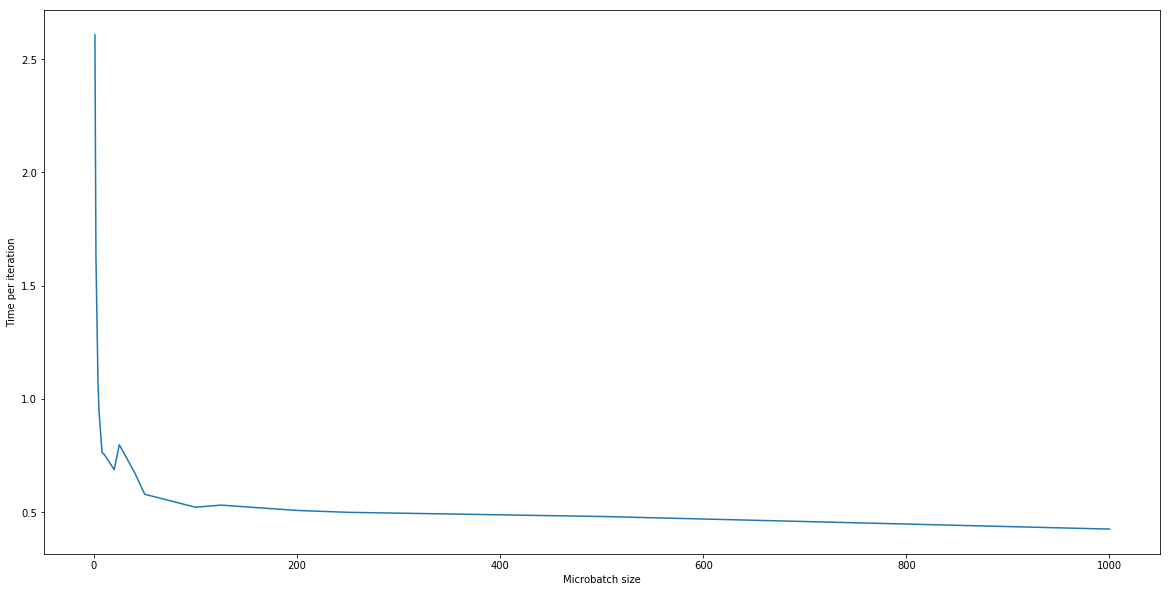

In [32]:
plt.figure(figsize = (20,10))
plt.plot(grid, time_per_iter)
plt.xlabel('Microbatch size')
plt.ylabel('Time per iteration')
plt.show()

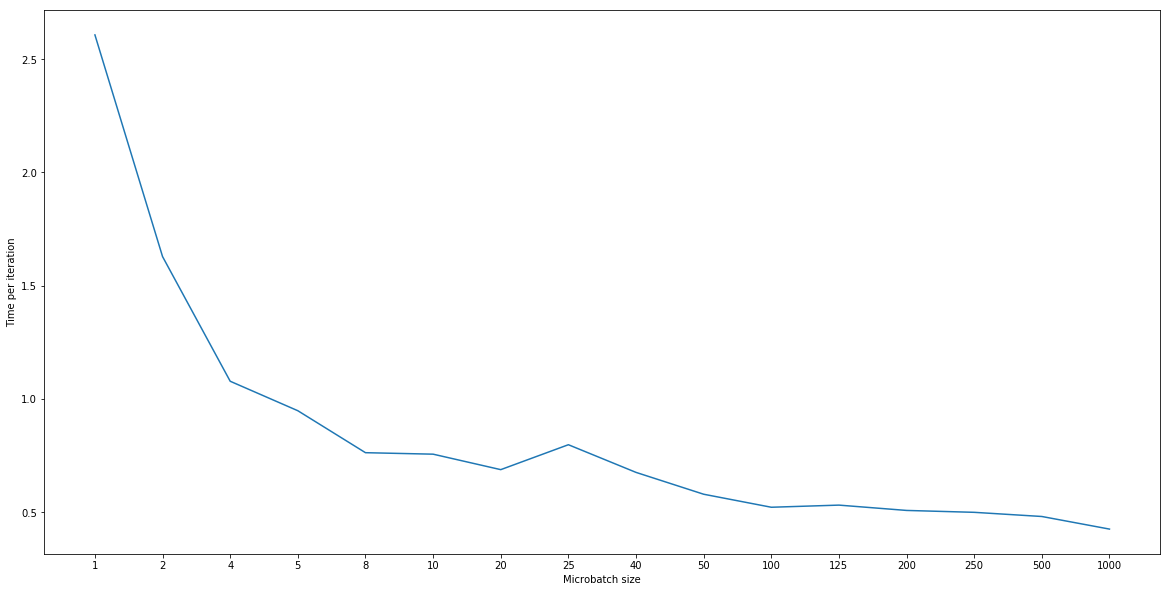

In [34]:
plt.figure(figsize = (20,10))
plt.plot(time_per_iter)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Microbatch size')
plt.ylabel('Time per iteration')
plt.show()